Mini Project:

Dock 9 Compounds Against Protein COVID-19 Mpro (6LU7)

In [1]:
# STEP 1: Install required tools

!apt-get install -y openbabel > /dev/null
!pip install vina py3Dmol biopython rdkit > /dev/null


In [2]:
# import libraries
import os
from vina import Vina
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

In [3]:
# STEP 2: Download Protein (COVID-19 Mpro = 6LU7)
!wget -q "https://files.rcsb.org/download/6LU7.pdb" -O protein.pdb

In [4]:
# STEP 3: Prepare Protein (remove water, keep chain A)
from Bio.PDB import PDBParser, PDBIO, Select

class ChainSelect(Select):
    def __init__(self, chain):
        self.chain = chain
    def accept_chain(self, chain):
        return chain.get_id() == self.chain
    def accept_residue(self, residue):
        return residue.id[0] == " "  # skip water

parser = PDBParser(QUIET=True)
structure = parser.get_structure("prot", "protein.pdb")
io = PDBIO()
io.set_structure(structure)
io.save("receptor.pdb", ChainSelect("A"))

In [5]:
# Convert protein.pdb -> receptor.pdbqt

# -xr : remove water
# -xh : add hydrogens
# --partialcharge gasteiger : assign charges
!obabel receptor.pdb -O receptor.pdbqt -xr -xh --partialcharge gasteiger

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is receptor.pdb)

1 molecule converted


In [6]:
# STEP 4: Ligand Preparation (9 ligands from SMILES)
ligands = {
    "aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "ibuprofen": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "theophylline": "CN1C2=C(C(=O)N(C1=O)C)NC=N2",
    "naringenin": "C1[C@H](OC2=CC(=CC(=C2C1=O)O)O)C3=CC=C(C=C3)O",
    "quercetin": "C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O",
    "curcumin": "COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(C=C2)O)OC)O",
    "resveratrol": "C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)O)O)O",
    "erlotinib": "COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC",
    "chloroquine": "CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl"
}


In [7]:
# Convert all ligands to pdbqt

import os
from rdkit import Chem
from rdkit.Chem import AllChem

os.makedirs("ligands", exist_ok=True)

for name, smi in ligands.items():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f" Failed to parse {name}")
        continue
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)
    Chem.MolToMolFile(mol, f"ligands/{name}.mol")

    # Convert MOL → PDBQT with hydrogens + Gasteiger charges
    !obabel ligands/{name}.mol -O ligands/{name}.pdbqt -xh --partialcharge gasteiger --gen3d

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted


In [8]:
# STEP 5: Docking with AutoDock Vina
from vina import Vina

vina = Vina(sf_name='vina', verbosity=0)

# Load receptor
print(" Loading receptor ...")
vina.set_receptor('receptor.pdbqt')

# Define docking box
print(" Computing docking maps ...")
vina.compute_vina_maps(center=[-10, 12, 68], box_size=[20, 20, 20])

results = {}

print("\n Starting AutoDock Vina Docking...\n")

for i, name in enumerate(ligands.keys(), 1):
    print(f"[{i}/{len(ligands)}] Docking {name} ... ")
    vina.set_ligand_from_file(f"ligands/{name}.pdbqt")
    vina.dock(n_poses=5)
    score = vina.energies()[0][0]
    results[name] = score
    vina.write_poses(f"ligands/{name}_out.pdbqt", n_poses=1, overwrite=True)
    print(f" {name} docking complete | Best score: {score:.2f} kcal/mol\n")

print(" Docking finished for all ligands!")
print("Results:", results)

 Loading receptor ...
 Computing docking maps ...

 Starting AutoDock Vina Docking...

[1/9] Docking aspirin ... 
 aspirin docking complete | Best score: -4.47 kcal/mol

[2/9] Docking ibuprofen ... 
 ibuprofen docking complete | Best score: -5.25 kcal/mol

[3/9] Docking theophylline ... 
 theophylline docking complete | Best score: -4.77 kcal/mol

[4/9] Docking naringenin ... 
 naringenin docking complete | Best score: -7.28 kcal/mol

[5/9] Docking quercetin ... 
 quercetin docking complete | Best score: -7.56 kcal/mol

[6/9] Docking curcumin ... 
 curcumin docking complete | Best score: -6.99 kcal/mol

[7/9] Docking resveratrol ... 
 resveratrol docking complete | Best score: -6.96 kcal/mol

[8/9] Docking erlotinib ... 
 erlotinib docking complete | Best score: -6.62 kcal/mol

[9/9] Docking chloroquine ... 
 chloroquine docking complete | Best score: -5.36 kcal/mol

 Docking finished for all ligands!
Results: {'aspirin': np.float64(-4.473), 'ibuprofen': np.float64(-5.254), 'theophylli

In [9]:
# STEP 6: Display Results
print("Docking Results (Binding Affinity, kcal/mol):")
for lig, score in results.items():
    print(f"{lig:12s}: {score:.2f}")

Docking Results (Binding Affinity, kcal/mol):
aspirin     : -4.47
ibuprofen   : -5.25
theophylline: -4.77
naringenin  : -7.28
quercetin   : -7.56
curcumin    : -6.99
resveratrol : -6.96
erlotinib   : -6.62
chloroquine : -5.36


RESULTS:

	•	Quercetin (-7.56) is the strongest binder in this set.

	•	Naringenin, Curcumin, Resveratrol also show strong docking scores (~ -7 kcal/mol).

	•	Aspirin & Theophylline are weaker binders (~ -4.5 kcal/mol).

In [17]:
# STEP 7: Visualize Best Docked Pose Quercetin (-7.56)  (Py3Dmol)
pose = open("ligands/quercetin_out.pdbqt").read()
view = py3Dmol.view(width=500, height=400)
view.addModel(open("receptor.pdb").read(),"pdb")
view.setStyle({"cartoon": {"color":"spectrum"}})
view.addModel(pose,"pdb")
view.setStyle({"model":1},{"stick":{}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

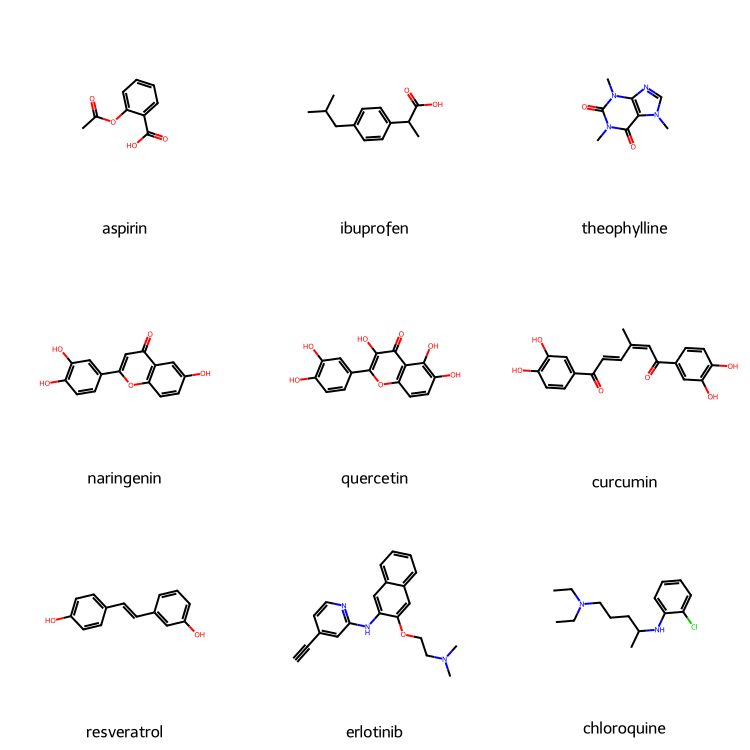

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw

# Define ligands (SMILES)
ligands = {
    "aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "ibuprofen": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "theophylline": "Cn1cnc2c1c(=O)n(c(=O)n2C)C",
    "naringenin": "C1=CC(=C(C=C1C2=CC(=O)C3=C(O2)C=CC(=C3)O)O)O",
    "quercetin": "C1=CC(=C(C=C1C2=C(C(=O)C3=C(O2)C=CC(=C3O)O)O)O)O",
    "curcumin": "CC(=CC(=O)C1=CC(=C(C=C1)O)O)C=CC(=O)C2=CC(=C(C=C2)O)O",
    "resveratrol": "C1=CC(=CC=C1/C=C/C2=CC(=CC=C2)O)O",
    "erlotinib": "CN(C)CCOC1=CC2=CC=CC=C2C=C1NC3=NC=CC(=C3)C#C",
    "chloroquine": "CCN(CC)CCCC(C)NC1=CC=CC=C1Cl"
}

# Convert to RDKit Mol objects
mols = [Chem.MolFromSmiles(smi) for smi in ligands.values()]

# Draw all molecules in a grid (3x3)
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(250, 250),
    legends=list(ligands.keys())
)
img